In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
df_combined=pd.read_csv(r'preprocessed_news_dataset.csv')
x_train, x_test, y_train, y_test = train_test_split(df_combined['text'], 
                                                    df_combined['label'], 
                                                    test_size=0.25,
                                                     random_state=42)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Handle missing values by replacing NaN with an empty string in the text data
x_train = x_train.fillna('')
x_test = x_test.fillna('')

# Apply TfidfVectorizer (converts text to numerical vectors)
vectorization = TfidfVectorizer(stop_words='english', max_df=0.7)
x_train_tfidf = vectorization.fit_transform(x_train)  # Transformed training data
x_test_tfidf = vectorization.transform(x_test)       # Transformed test data

# Initialize the Logistic Regression model
model = LogisticRegression()

# Train the model on the training data
model.fit(x_train_tfidf, y_train)

# Check accuracy on the training set
train_accuracy = accuracy_score(y_train, model.predict(x_train_tfidf))
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Check accuracy on the test set
test_accuracy = accuracy_score(y_test, model.predict(x_test_tfidf))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Training Accuracy: 99.19%
Test Accuracy: 98.57%


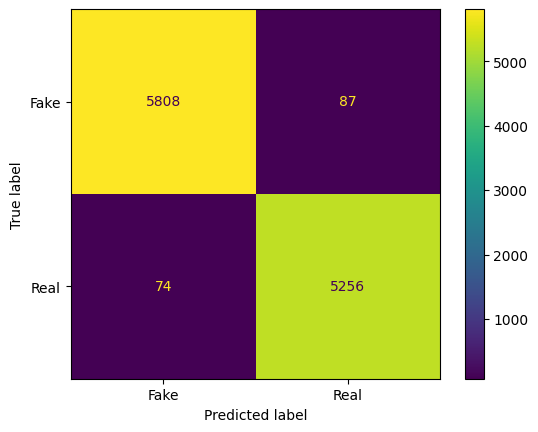

In [19]:
#confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
y_pred = model.predict(x_test_tfidf)
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=['Fake', 'Real'])
cm_display.plot()
plt.show()

In [20]:
from sklearn.metrics import classification_report, roc_auc_score

# Classification report
print(classification_report(y_test, y_pred))

# ROC-AUC score (for binary classification)
roc_auc = roc_auc_score(y_test, model.predict_proba(x_test_tfidf)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.2f}")


              precision    recall  f1-score   support

        FAKE       0.99      0.99      0.99      5895
        REAL       0.98      0.99      0.98      5330

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

ROC-AUC Score: 1.00


In [22]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder and fit on y_train and y_test
label_encoder = LabelEncoder()

# Fit on y_train and transform both y_train and y_test
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Now y_train_encoded and y_test_encoded are numeric (0 and 1)


In [23]:
# Train the model using encoded labels
model.fit(x_train_tfidf, y_train_encoded)


LogisticRegression()

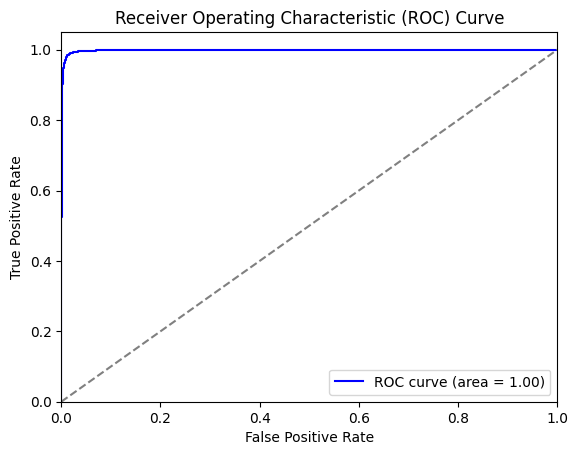

In [24]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Get the predicted probabilities
y_pred_prob = model.predict_proba(x_test_tfidf)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [25]:
from sklearn.model_selection import GridSearchCV

# Example for hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(x_train_tfidf, y_train)

print(f"Best Parameters: {grid_search.best_params_}")


Best Parameters: {'C': 10, 'max_iter': 100}


In [26]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, x_train_tfidf, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Average CV score: {cv_scores.mean()}")


Cross-validation scores: [0.98411284 0.98203415 0.98604306 0.98336798 0.98396198]
Average CV score: 0.9839040038594604


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

# Reinitialize the vectorizer with stop words removal and maximum document frequency set to 0.7
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Fit the vectorizer on the training data (x_train) and transform the training data into TF-IDF features
x_train_tfidf = vectorizer.fit_transform(x_train)  # Transform the training data

# Now transform the test data using the fitted vectorizer (x_test)
x_test_tfidf = vectorizer.transform(x_test)  # Transform the test data

# Predict the labels for the test data using the trained model
y_pred = model.predict(x_test_tfidf)

# Map integer predictions to the string labels
label_map = {0: 'REAL', 1: 'FAKE'}
y_pred_labels = [label_map[label] for label in y_pred]

# Evaluate performance using the classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred_labels))
cm = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:\n", cm)








Classification Report:
               precision    recall  f1-score   support

        FAKE       0.02      0.01      0.02      5895
        REAL       0.01      0.01      0.01      5330

    accuracy                           0.01     11225
   macro avg       0.01      0.01      0.01     11225
weighted avg       0.01      0.01      0.01     11225

Confusion Matrix:
 [[  87 5808]
 [5256   74]]


In [32]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced')
model.fit(x_train_tfidf, y_train)
y_pred = model.predict(x_test_tfidf)


In [33]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, model.predict_proba(x_test_tfidf)[:, 1])
print(f"AUC-ROC: {roc_auc}")


AUC-ROC: 0.9984737916668657


In [34]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced')


In [35]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_tfidf, y_train)
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the model with the best hyperparameters
model = LogisticRegression(C=10, penalty='l2', solver='liblinear')
model.fit(x_train_tfidf, y_train)

# Predict on the test set
y_pred = model.predict(x_test_tfidf)

# Evaluate performance
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Classification Report:
               precision    recall  f1-score   support

        FAKE       0.99      1.00      0.99      5895
        REAL       0.99      0.99      0.99      5330

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

Confusion Matrix:
 [[5868   27]
 [  40 5290]]


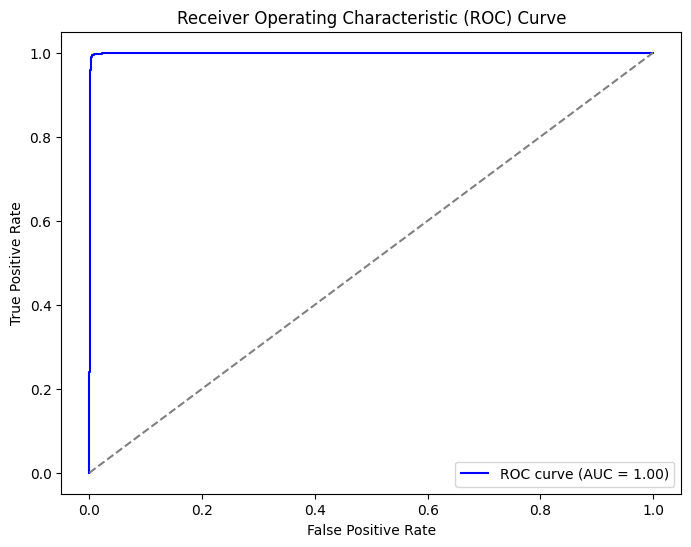

AUC-ROC: 0.9994236856050298


In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Convert y_test and y_pred to numeric values (FAKE = 0, REAL = 1)
label_encoder = LabelEncoder()
y_test_numeric = label_encoder.fit_transform(y_test)  # This converts 'FAKE' to 0 and 'REAL' to 1
y_pred_proba = model.predict_proba(x_test_tfidf)[:, 1]  # Probability for the positive class ('REAL')

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_numeric, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("AUC-ROC:", roc_auc)


In [40]:
import joblib
import pickle

# Save the model and vectorizer using joblib
joblib.dump(model, 'fake_news_model.pkl')  # Save the trained model
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')  # Save the vectorizer

# To load the model and vectorizer later
loaded_model = joblib.load('fake_news_model.pkl')  # Load the model
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')  # Load the vectorizer

# Now you can use the loaded model and vectorizer to make predictions
# Example: Transform new data and make predictions
new_data = ["Sample news text here."]
new_data_tfidf = loaded_vectorizer.transform(new_data)  # Transform new data
y_pred = loaded_model.predict(new_data_tfidf)  # Predict using the loaded model

print("Predicted class for the new data:", y_pred)


Predicted class for the new data: ['FAKE']


In [41]:
# Save the model and vectorizer again in a safe way
import pickle

# Assuming your model is named `model` and vectorizer is `vectorizer`
with open('fake_news_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)
